In [1]:
!pip install langchain langchain-community langchain-openai
!pip install faiss-cpu
!pip install pymupdf
!pip install sentence-transformers
!pip install openai
!pip install chromadb

   ---------------------------------------- 0.0/725.5 kB ? eta -:--:--
   ---------------------------------------- 725.5/725.5 kB 9.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/894.9 kB ? eta -:--:--
   ---------------------------------------- 894.9/894.9 kB 8.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.0 MB ? eta -:--:--
   --------- ------------------------------ 3.4/15.0 MB 16.7 MB/s eta 0:00:01
   ------------------- -------------------- 7.3/15.0 MB 17.4 MB/s eta 0:00:01
   ------------------------------ --------- 11.3/15.0 MB 18.1 MB/s eta 0:00:01
   ---------------------------------------  14.9/15.0 MB 17.7 MB/s eta 0:00:01
   ---------------------------------------- 15.0/15.0 MB 16.0 MB/s eta 0:00:00


# 1단계:김문수 vs 이재명 후보의 공약 기반 AI Agent를 빠르게 시험

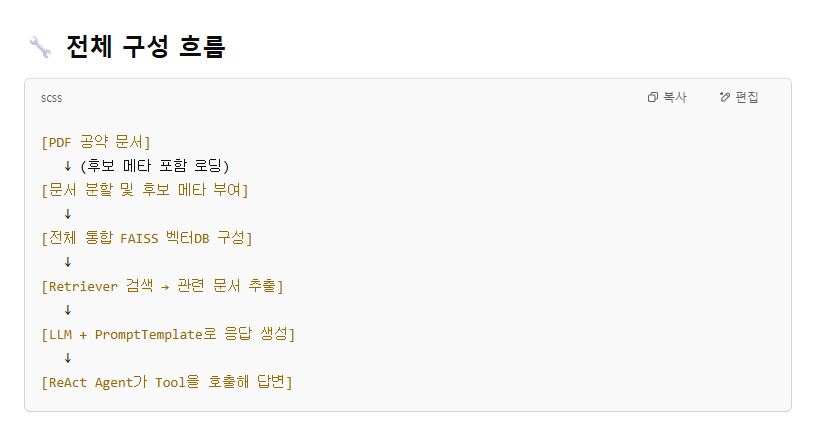

In [2]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.chains.question_answering import load_qa_chain
from langchain.chat_models import ChatOpenAI
from langchain.agents import Tool, initialize_agent
from langchain.agents.agent_types import AgentType

# 1. API 키 설정
import os
os.environ['OPENAI_API_KEY'] = '' # 본인의 키를 넣어주세요.

# ===============================
# Step 1. PDF 로딩 및 후보 정보 부여
# ===============================
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}

all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
        all_documents.extend(data)

# ===============================
# Step 2. 텍스트 분할
# ===============================
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# ===============================
# Step 3. 벡터스토어 생성 (후보 이름 포함)
# ===============================
embeddings_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings':True},
)
vectorstore = FAISS.from_documents(documents, embedding=embeddings_model)

# ===============================
# Step 4. 프롬프트 템플릿 정의 및 QA 체인 구성 (ReAct 사용 가능 구조)
# FAISS retriever → 문서 검색 → LLM에 전달 → 응답 반환
# ===============================
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
다음은 두 대통령 후보의 공약이다. 문맥을 참고하여 질문에 답변하라.

문맥:
{context}

질문:
{question}

답변:
""")

retriever = vectorstore.as_retriever(search_kwargs={"k": 6}) #상위 6개의 유사한 문서 조각(chunks)을 반환함
llm = ChatOpenAI(temperature=0.3) #창의성 제어 수치 (0.0 = 완전 결정적, 1.0 = 매우 창의적)

#“질문 → 관련 문서 검색 → LLM으로 답변 생성” 흐름을 구성
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff", #문서를 어떻게 LLM에 넣을지 방식 설정. stuff는 문서들을 하나로 이어 붙여서 넣는 방식
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt_template} #LLM에게 넘겨줄 프롬프트 템플릿 설정
)

# ===============================
# Step 5. 툴 정의 및 ReAct Agent 구성
# Tool 객체로 QA 체인 기능을 wrapping
# ===============================
tools = [
    Tool(
        name="ElectionPolicySearch",
        func=qa_chain.run,
        description="대통령 후보 공약을 기반으로 질문에 답하는 도우미 도구입니다."
    )
]

react_agent = initialize_agent(
    tools=tools, #Agent가 사용할 수 있는 도구 목록
    llm=llm,       #Agent 내부에서 사용하는 언어 모델
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, #"도구 이름 + 설명"만 있으면 GPT가 추론을 통해 직접 도구를 골라 사용함
    verbose=True
)



ValueError: File path 20250603_대한민국_이재명_10대공약.pdf is not a valid file or url

In [ ]:
# ===============================
# Step 6. 예시 질의 실행
# ===============================

# 예시 질의 목록
example_queries = [
    "김문수 후보의 GTX 확장 계획은 무엇인가요?",
    # "이재명 후보는 공공의료를 어떻게 강화하려고 하나요?",
    # "두 후보는 AI 산업을 어떻게 육성하려고 하나요?",
    # "서울에서 자취 중인 20대입니다. 주거 지원 공약이 있나요?",
    # "AI 창업을 준비 중인 청년에게 도움이 될 공약이 있나요?",
    # "소상공인 지원 공약은 어떤 후보가 더 실질적인가요?"
]

# 각 질문에 대해 Agent 실행
for q in example_queries:
    print(f"\n🟡 질문: {q}\n")
    response = react_agent.run(q)
    print(f"🟢 응답:\n{response}\n")
    print("=" * 80)


In [ ]:
import pandas as pd
# 테스트 질문 및 기대 키워드 정의
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["지역돌봄체계", "모든 사람의 권리가 보장", "국가책임제"]
    }
]

# 평가 수행
results = []
for case in test_cases:
    response = react_agent.run(case["질문"])
    matched = sum(1 for kw in case["기대 키워드"] if kw in response)
    accuracy = round((matched / len(case["기대 키워드"])) * 5, 2)
    richness = 5 if len(response) > 400 and matched >= 3 else 3 if matched else 1
    results.append({
        "질문": case["질문"],
        "응답": response,
        "정확성 점수(1~5)": accuracy,
        "풍부성 점수(1~5)": richness
    })

df_result = pd.DataFrame(results)

df_result

# 2단계: 프롬프트 개선
- 문제의 원인 분석
- 문서 검색 (retriever)	성공적으로 관련 chunk는 찾아냄
-  GPT 응답 형식은 응답을 너무 일반화된 문장으로 축소함 → 핵심 키워드 누락
-  프롬프트는	“공약의 수단, 대상, 용어, 수치 등을 구체적으로 제시하라”는 지시가 부족


In [ ]:
TAMPLATE_2 = """
아래 문서는 대통령 후보의 공약이다. 질문에 대해 다음 요소를 포함하여 답변하라:
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 한국어로

문맥:
{context}

질문:
{question}

답변:
"""


In [ ]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.chains.question_answering import load_qa_chain
from langchain.chat_models import ChatOpenAI
from langchain.agents import Tool, initialize_agent
from langchain.agents.agent_types import AgentType

# 1. API 키 설정
import os
os.environ['OPENAI_API_KEY'] = '' # 본인의 키를 넣어주세요.

# ===============================
# Step 1. PDF 로딩 및 후보 정보 부여
# ===============================
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}

all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
        all_documents.extend(data)

# ===============================
# Step 2. 텍스트 분할
# ===============================
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# ===============================
# Step 3. 벡터스토어 생성 (후보 이름 포함)
# ===============================
embeddings_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings':True},
)
vectorstore = FAISS.from_documents(documents, embedding=embeddings_model)

# ===============================
# Step 4. 프롬프트 템플릿 정의 및 QA 체인 구성 (ReAct 사용 가능 구조)
# FAISS retriever → 문서 검색 → LLM에 전달 → 응답 반환
# ===============================
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template=TAMPLATE_2)

retriever = vectorstore.as_retriever(search_kwargs={"k": 6}) #상위 6개의 유사한 문서 조각(chunks)을 반환함
llm = ChatOpenAI(temperature=0.3) #창의성 제어 수치 (0.0 = 완전 결정적, 1.0 = 매우 창의적)

#“질문 → 관련 문서 검색 → LLM으로 답변 생성” 흐름을 구성
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff", #문서를 어떻게 LLM에 넣을지 방식 설정. stuff는 문서들을 하나로 이어 붙여서 넣는 방식
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt_template} #LLM에게 넘겨줄 프롬프트 템플릿 설정
)

# ===============================
# Step 5. 툴 정의 및 ReAct Agent 구성
# Tool 객체로 QA 체인 기능을 wrapping
# ===============================
tools = [
    Tool(
        name="ElectionPolicySearch",
        func=qa_chain.run,
        description="대통령 후보 공약을 기반으로 질문에 답하는 도우미 도구입니다."
    )
]

react_agent = initialize_agent(
    tools=tools, #Agent가 사용할 수 있는 도구 목록
    llm=llm,       #Agent 내부에서 사용하는 언어 모델
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, #"도구 이름 + 설명"만 있으면 GPT가 추론을 통해 직접 도구를 골라 사용함
    verbose=True
)


In [ ]:
import pandas as pd

# 테스트 질문 및 기대 키워드 정의
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["발달장애인", "24시간 돌봄", "지역돌봄체계", "간병비", "공공신탁제도"]
    }
]

# 평가 수행
results = []
for case in test_cases:
    response = react_agent.run(case["질문"])
    matched_keywords = [kw for kw in case["기대 키워드"] if kw in response]
    accuracy = round((len(matched_keywords) / len(case["기대 키워드"])) * 5, 2)
    richness = 5 if len(response) > 400 and len(matched_keywords) >= 3 else 3 if matched_keywords else 1
    results.append({
        "질문": case["질문"],
        "응답": response,
        "일치 키워드": matched_keywords,
        "정확성 점수(1~5)": accuracy,
        "풍부성 점수(1~5)": richness
    })

df_result = pd.DataFrame(results)
df_result


>

# 3단계:성능 검증을 위한 출처 추가
- 핵심 변경 사항
RetrievalQA 대신 load_qa_chain을 사용하여 문서 출처 포함을 제어할 수 있습니다.

In [ ]:
# 전체 코드 재정리: 출처에 페이지 번호 포함

from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.agents import Tool, initialize_agent
from langchain.agents.agent_types import AgentType
import os
import pandas as pd

# ✅ API 키 설정
import os
os.environ['OPENAI_API_KEY'] = ''

# ✅ Step 1. PDF 로딩 및 후보 정보 부여 + 출처 설정 (페이지 포함)
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{path.split('/')[-1]}:p{page}"  # ✅ 출처 형식 수정
        all_documents.extend(data)

# ✅ Step 2. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# ✅ Step 3. 벡터스토어 생성
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
vectorstore = FAISS.from_documents(documents, embedding=embedding_model)

# ✅ Step 4. 프롬프트 및 QA 체인 정의
TAMPLATE_2 = """
아래 문서는 대통령 후보의 공약이다. 질문에 대해 다음 요소를 포함하여 답변하라:
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

문맥:
{summaries}

질문:
{question}

답변:
"""
prompt_template = PromptTemplate(
    input_variables=["summaries", "question"],
    template=TAMPLATE_2
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 6})
llm = ChatOpenAI(temperature=0.3)

qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
    chain_type_kwargs={"prompt": prompt_template},
    return_source_documents=True  # ✅ 출처 추출하기위해
)

# ✅ Step 5. ReAct Agent 구성
tools = [
    Tool(
        name="ElectionPolicySearch",
        func=lambda q: qa_chain.invoke({"question": q}),  # invoke로 dict 반환
        description="대통령 후보 공약을 기반으로 질문에 답하는 도우미 도구입니다."
    )
]
react_agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

# ✅ Step 6. 테스트 및 평가
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["발달장애인", "24시간 돌봄", "지역돌봄체계", "간병비", "공공신탁제도"]
    }
]

results = []
for case in test_cases:
    # result = react_agent.run(case["질문"])  # 이 부분은 str만 반환됨
    # 전체 정보가 필요할 경우 아래를 직접 수행
    qa_result = qa_chain.invoke({"question": case["질문"]})
    answer = qa_result["answer"]
    docs = qa_result.get("source_documents", [])
    sources = [f"{doc.metadata.get('source')}" for doc in docs]

    matched_keywords = [kw for kw in case["기대 키워드"] if kw in answer]
    accuracy = round((len(matched_keywords) / len(case["기대 키워드"])) * 5, 2)
    richness = 5 if len(answer) > 400 and len(matched_keywords) >= 3 else 3 if matched_keywords else 1

    results.append({
        "질문": case["질문"],
        "응답": answer,
        "출처": sources,
        "일치 키워드": matched_keywords,
        "정확성 점수(1~5)": accuracy,
        "풍부성 점수(1~5)": richness
    })


df_result = pd.DataFrame(results)

df_result



>  [문제 원인]
>  - 김문수 후보에 대한 질의에 이재명 후보의 공약 문서까지 포함되어 검색되고 있다는 것은,
현재 RAG 시스템이 후보 구분 없이 전체 문서에서 유사도 기반 검색을 하고 있다는 뜻입니다.

> - 현재
retriever = vectorstore.as_retriever(search_kwargs={"k": 6})
→ 이 설정은 이재명, 김문수 모든 후보의 문서가 하나의 벡터 공간에 저장되어 있고, 질의에 대해 후보 구분 없이 유사 문서를 찾게 만듭니다.


# 4단계:FAISS에서 ChromaDB로 변경

- Chroma를 사용하면서 후보별 질의와 후보 간 비교까지 지원하려면, 핵심은 candidate 메타데이터를 기준으로 필터링이 가능한 Retriever 구성

In [ ]:
!pip install chromadb

In [ ]:
# 후보 이름 자동 감지 포함 전체 코드 (Chroma 기반)

from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain
import pandas as pd
import os

# ✅ API 키 설정
os.environ['OPENAI_API_KEY'] = ''

# ✅ Step 1. PDF 로딩 및 후보 정보 메타데이터 추가
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{os.path.basename(path)}:p{page}"
        all_documents.extend(data)

# ✅ Step 2. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# ✅ Step 3. Chroma 벡터스토어 생성
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
chroma_db_path = "chroma_db"
vectorstore = Chroma.from_documents(documents, embedding=embedding_model, persist_directory=chroma_db_path)
vectorstore.persist()

# ✅ Step 4. 프롬프트 및 후보별 QA 체인 정의
TEMPLATE = """
아래 문서는 대통령 후보의 공약이다. 질문에 대해 다음 요소를 포함하여 답변하라:
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

문맥:
{summaries}

질문:
{question}

답변:
"""
prompt_template = PromptTemplate(
    input_variables=["summaries", "question"],
    template=TEMPLATE
)

llm = ChatOpenAI(temperature=0.3)

retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "김문수"}})
}

qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# ✅ Step 5. 후보 이름 자동 감지 함수
def detect_candidate(question: str):
    if "이재명" in question:
        return "이재명"
    elif "김문수" in question:
        return "김문수"
    else:
        return None

# ✅ Step 6. 테스트 및 평가
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["발달장애인", "24시간 돌봄", "지역돌봄체계", "간병비", "공공신탁제도"]
    }
]

results = []
for case in test_cases:
    candidate = detect_candidate(case["질문"])
    if candidate and candidate in qa_chains:
        qa_result = qa_chains[candidate].invoke({"question": case["질문"]})
        answer = qa_result["answer"]
        docs = qa_result.get("source_documents", [])
        sources = [f"{doc.metadata.get('source')}" for doc in docs]

        matched_keywords = [kw for kw in case["기대 키워드"] if kw in answer]
        accuracy = round((len(matched_keywords) / len(case["기대 키워드"])) * 5, 2)
        richness = 5 if len(answer) > 400 and len(matched_keywords) >= 3 else 3 if matched_keywords else 1

        results.append({
            "질문": case["질문"],
            "응답": answer,
            "출처": ", ".join(sources),
            "일치 키워드": ", ".join(matched_keywords),
            "정확성 점수(1~5)": accuracy,
            "풍부성 점수(1~5)": richness
        })

df_result = pd.DataFrame(results)
df_result



# 5단계:고급 프롬프트 적용:prompte chaining
- 질문 입력 → 후보 감지 → vectorstore 검색 → GPT 응답
- 예: "이재명 후보의 부동산 정책은?" → "이재명" 추출 → Chroma filter → GPT 응답


In [ ]:
# 전체 실행 코드: Prompt Chaining 기반 대통령 후보 공약 질의 시스템

from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain, LLMChain
import pandas as pd
import os

# ✅ 1. API 설정 및 모델 초기화
os.environ['OPENAI_API_KEY'] = ''
llm = ChatOpenAI(temperature=0.3)

# ✅ 2. 문서 로딩 및 후보 메타데이터 추가
file_paths = {
    "이재명": ["20250603_대한민국_이재명_10대공약.pdf", "20250603_대한민국_이재명_선거공약서.pdf"],
    "김문수": ["20250603_대한민국_김문수_10대공약.pdf", "20250603_대한민국_김문수_선거공약서.pdf"],
}
all_documents = []
for name, paths in file_paths.items():
    for path in paths:
        loader = PyMuPDFLoader(path)
        data = loader.load()
        for d in data:
            d.metadata["candidate"] = name
            page = d.metadata.get("page", "?")
            d.metadata["source"] = f"{os.path.basename(path)}:p{page}"
        all_documents.extend(data)

# ✅ 3. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200, encoding_name='cl100k_base'
)
documents = text_splitter.split_documents(all_documents)

# ✅ 4. Chroma 벡터 저장소 생성
embedding_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sbert-nli',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
)
vectorstore = Chroma.from_documents(documents, embedding=embedding_model, persist_directory="chroma_db")
vectorstore.persist()

# ✅ 5. 프롬프트 정의 및 후보별 QA 체인 구성
prompt_template = PromptTemplate(
    input_variables=["summaries", "question"],
    template="""
아래 문서는 대통령 후보의 공약이다. 질문에 대해 다음 요소를 포함하여 답변하라:
- 정책의 목적
- 구체적 수단 (시설, 제도, 법안 등)
- 실행 대상 또는 지역
- 문서상 등장한 구체적인 단어(용어)를 사용
- 반드시 한국어로 답변할 것

문맥:
{summaries}

질문:
{question}

답변:
"""
)

retrievers = {
    "이재명": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "이재명"}}),
    "김문수": vectorstore.as_retriever(search_kwargs={"k": 6, "filter": {"candidate": "김문수"}})
}

qa_chains = {
    name: RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt_template},
        return_source_documents=True
    ) for name, retriever in retrievers.items()
}

# ✅ 6. 후보명 추출용 체인 구성 (Prompt Chaining 핵심)
candidate_prompt = PromptTemplate(
    input_variables=["question"],
    template="다음 질문에서 언급된 대통령 후보의 이름을 정확히 추출하시오.\n\n질문: {question}\n후보 이름:"
)
candidate_chain = LLMChain(llm=llm, prompt=candidate_prompt)

# ✅ 7. 전체 실행 체인
def run_prompt_chaining(question: str, expected_keywords: list):
    detected_name = candidate_chain.run({"question": question}).strip()
    candidate = None
    for name in qa_chains:
        if name in detected_name:
            candidate = name
            break

    if not candidate:
        return {
            "질문": question,
            "후보": "감지 실패",
            "응답": "질문에서 후보 이름을 인식하지 못했습니다.",
            "출처": "",
            "일치 키워드": "",
            "정확성 점수(1~5)": 1,
            "풍부성 점수(1~5)": 1
        }

    qa_result = qa_chains[candidate].invoke({"question": question})
    answer = qa_result["answer"]
    docs = qa_result.get("source_documents", [])
    sources = [f"{doc.metadata.get('source')}" for doc in docs]

    matched_keywords = [kw for kw in expected_keywords if kw in answer]
    accuracy = round((len(matched_keywords) / len(expected_keywords)) * 5, 2)
    richness = 5 if len(answer) > 400 and len(matched_keywords) >= 3 else 3 if matched_keywords else 1

    return {
        "질문": question,
        "후보": candidate,
        "응답": answer,
        "출처": ", ".join(sources),
        "일치 키워드": ", ".join(matched_keywords),
        "정확성 점수(1~5)": accuracy,
        "풍부성 점수(1~5)": richness
    }

# ✅ 8. 테스트 케이스 실행
test_cases = [
    {
        "질문": "김문수 후보의 GTX 확장 계획은 무엇인가요?",
        "기대 키워드": ["GTX", "전국 5대 광역권", "수도권", "초광역", "교통 체증"]
    },
    {
        "질문": "이재명 후보는 발달장애인 돌봄에 대해 어떤 정책을 제안했나요?",
        "기대 키워드": ["발달장애인", "24시간 돌봄", "지역돌봄체계", "간병비", "공공신탁제도"]
    }
]

results = [run_prompt_chaining(tc["질문"], tc["기대 키워드"]) for tc in test_cases]
df_final = pd.DataFrame(results)

df_final
